**This notebook is an exercise in the [Time Series](https://www.kaggle.com/learn/time-series) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/seasonality).**

---


# Introduction #

Run this cell to set everything up!

In [1]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.time_series.ex3 import *

# Setup notebook
from pathlib import Path
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_periodogram, seasonal_plot

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


comp_dir = Path('../input/store-sales-time-series-forecasting')

holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

-------------------------------------------------------------------------------

Examine the following seasonal plot:

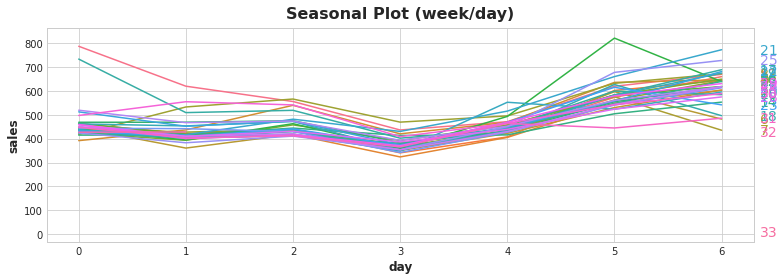

In [2]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

And also the periodogram:

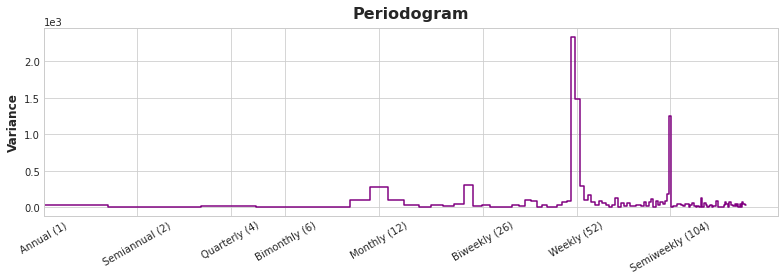

In [3]:
plot_periodogram(average_sales);

# 1) Determine seasonality

What kind of seasonality do you see evidence of? Once you've thought about it, run the next cell for some discussion.

In [4]:
# View the solution (Run this cell to receive credit!)
q_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

Both the seasonal plot and the periodogram suggest a strong weekly seasonality. From the periodogram, it appears there may be some monthly and biweekly components as well. In fact, the notes to the *Store Sales* dataset say wages in the public sector are paid out biweekly, on the 15th and last day of the month -- a possible origin for these seasons.


-------------------------------------------------------------------------------

# 2) Create seasonal features

Use `DeterministicProcess` and `CalendarFourier` to create:
- indicators for weekly seasons and
- Fourier features of order 4 for monthly seasons.

In [6]:
y = average_sales.copy()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

# Check your answer
q_2.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [5]:
# Lines below will give you a hint or solution code
q_2.hint()
q_2.solution()

<IPython.core.display.Javascript object>

<span style="color:#3366cc">Hint:</span> Your answer should look like:
```python
y = average_sales.copy()

fourier = CalendarFourier(____)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=____,
    additional_terms=[____],
    drop=True,
)
X = dp.in_sample()
```


<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python

y = average_sales.copy()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

```

Now run this cell to fit the seasonal model.

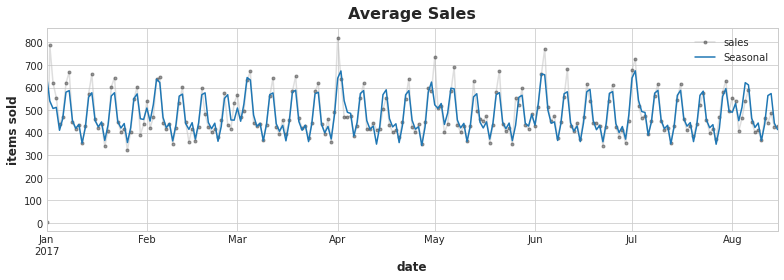

In [7]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

-------------------------------------------------------------------------------


Removing from a series its trend or seasons is called **detrending** or **deseasonalizing** the series.

Look at the periodogram of the deseasonalized series.

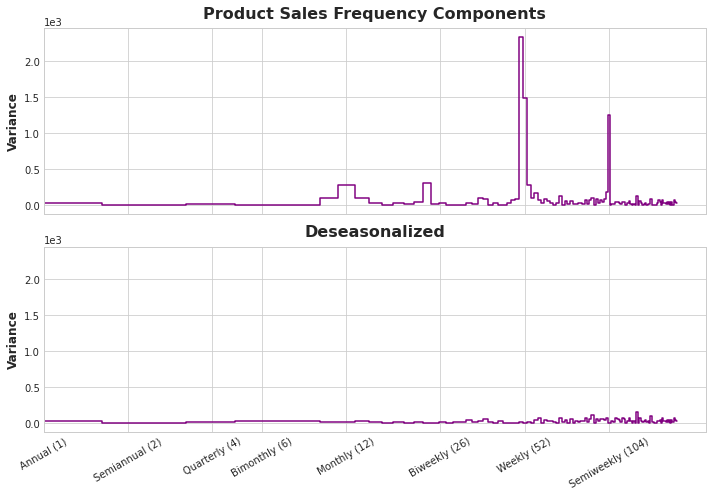

In [8]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

# 3) Check for remaining seasonality

Based on these periodograms, how effectively does it appear your model captured the seasonality in *Average Sales*? Does the periodogram agree with the time plot of the deseasonalized series?

In [9]:
# View the solution (Run this cell to receive credit!)
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

The periodogram for the deseasonalized series lacks any large values. By comparing it to the periodogram for the original series, we can see that our model was able to capture the seasonal variation in *Average Sales*.


-------------------------------------------------------------------------------

The *Store Sales* dataset includes a table of Ecuadorian holidays.

In [10]:
# National and regional holidays in the training set
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


From a plot of the deseasonalized *Average Sales*, it appears these holidays could have some predictive power.

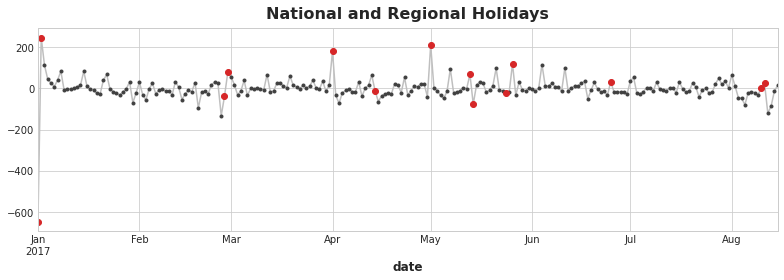

In [11]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays');

# 4) Create holiday features

What kind of features could you create to help your model make use of this information? Code your answer in the next cell. (Scikit-learn and Pandas both have utilities that should make this easy. See the `hint` if you'd like more details.)


In [13]:
# Scikit-learn solution
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)

X_holidays = pd.DataFrame(
    ohe.fit_transform(holidays),
    index=holidays.index,
    columns=holidays.description.unique(),
)


# Pandas solution
X_holidays = pd.get_dummies(holidays)


# Join to training data
X2 = X.join(X_holidays, on='date').fillna(0.0)


# Check your answer
q_4.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [12]:
# Lines below will give you a hint or solution code
#q_4.hint()
#q_4.hint(2)
q_4.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python

# Scikit-learn solution
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)

X_holidays = pd.DataFrame(
    ohe.fit_transform(holidays),
    index=holidays.index,
    columns=holidays.description.unique(),
)


# Pandas solution
X_holidays = pd.get_dummies(holidays)


# Join to training data
X2 = X.join(X_holidays, on='date').fillna(0.0)

```

Use this cell to fit the seasonal model with holiday features added. Do the fitted values seem to have improved?

In [ ]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X2), index=X2.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

-------------------------------------------------------------------------------

# (Optional) Submit to Store Sales competition

This part of the exercise will walk you through your first submission to this course's companion competition: [**Store Sales - Time Series Forecasting**](https://www.kaggle.com/c/29781). Submitting to the competition isn't required to complete the course, but it's a great way to try out your new skills.

The next cell creates a seasonal model of the kind you've learned about in this lesson for the full *Store Sales* dataset with all 1800 time series.

In [ ]:
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

You can use this cell to see some of its predictions.


In [ ]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'PRODUCE'
# Uncomment to see a list of product families
# display(store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

Finally, this cell loads the test data, creates a feature set for the forecast period, and then creates the submission file `submission.csv`.

In [ ]:
df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)


y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)

To test your forecasts, you'll need to join the competition (if you haven't already). So open a new window by clicking on [this link](https://www.kaggle.com/c/29781). Then click on the **Join Competition** button.

Next, follow the instructions below:
1. Begin by clicking on the **Save Version** button in the top right corner of the window.  This will generate a pop-up window.  
2. Ensure that the **Save and Run All** option is selected, and then click on the **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the file you would like to submit, and click on the **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

If you want to keep working to improve your performance, select the **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.


# Keep Going #

[**Use time series as features**](https://www.kaggle.com/ryanholbrook/time-series-as-features) to capture cycles and other kinds of serial dependence.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/time-series/discussion) to chat with other learners.*